In [1]:
!pip install pmdarima

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings

In [3]:
from math import sqrt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [4]:
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('../../data/sensor1.csv')

In [6]:
df = df.dropna()

In [7]:
units_dict = {}

for col in df.columns[1:]:
    values = []
    units = set()
    for val in df[col]:
        value, unit = val.split()
        values.append(value)
        units.add(unit)
    new_col_name = f"{col} ({units.pop()})"
    df.rename(columns={col: new_col_name}, inplace=True)
    df[new_col_name] = pd.to_numeric(values)
    units_dict[col] = units

In [8]:
df['Time'] = pd.to_datetime(df['Time'])

In [9]:
df.index = df['Time']
df.drop(columns=['Time'], inplace=True)

In [10]:
df = df.sort_index()

In [11]:
co2 = df["CO2 (ppm)"]

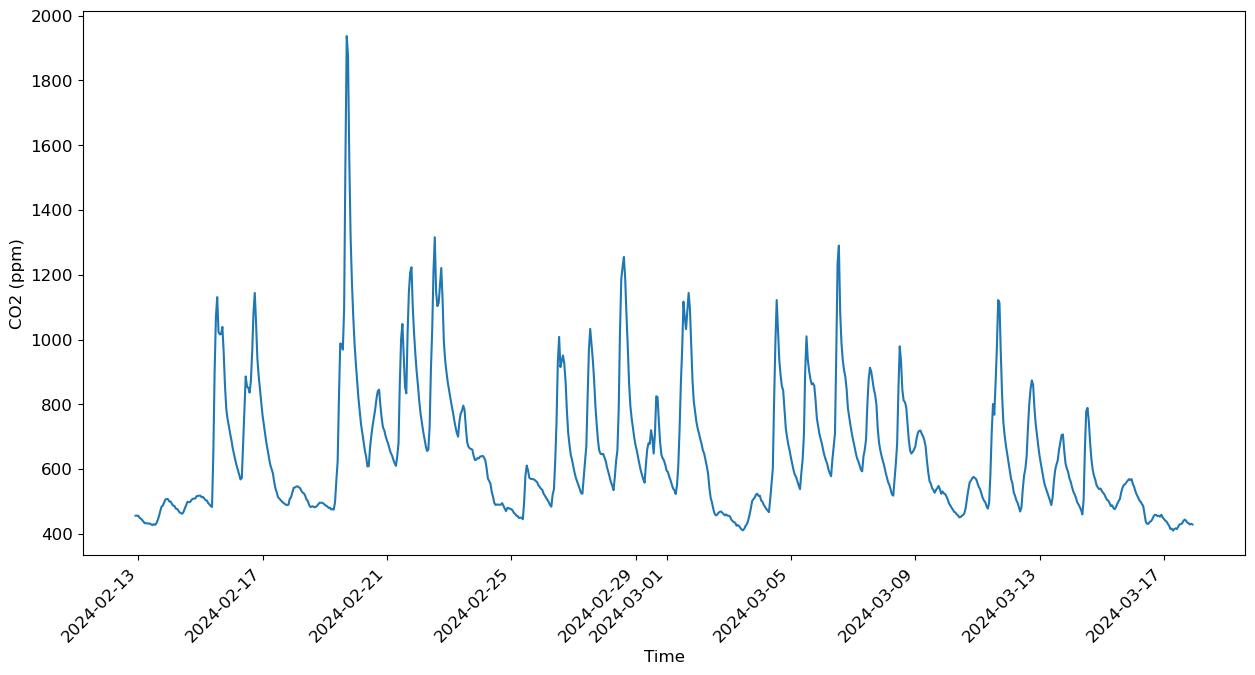

In [12]:
co2.plot(y='CO2 (ppm)', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('CO2 (ppm)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Create training and testing datasets

In [13]:
train_size = int(0.8 * len(df))

In [14]:
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

In [15]:
train_start_dt = train_df.index[0]
test_start_dt = test_df.index[0]

In [16]:
train_start_dt, test_start_dt

(Timestamp('2024-02-12 22:00:00'), Timestamp('2024-03-11 04:00:00'))

In [17]:
df

,CO2 (ppm),Humidity (%H),PM10 (μg/m³),PM2.5 (μg/m³),Temperature (°C),TVOC (ppm)
Time,,,,,,
2024-02-12 22:00:00,456,79.0,5.60,5.60,24.0,0.642
2024-02-12 23:00:00,456,79.0,5.25,5.13,24.1,0.711
2024-02-13 00:00:00,456,79.0,6.00,5.89,24.2,0.744
2024-02-13 01:00:00,450,79.0,6.44,6.33,24.2,0.759
2024-02-13 02:00:00,447,79.0,6.25,5.88,24.3,0.775
...,...,...,...,...,...,...
2024-03-17 18:00:00,435,77.5,19.00,18.70,25.4,0.468
2024-03-17 19:00:00,433,77.5,19.50,18.80,25.3,0.437
2024-03-17 20:00:00,429,77.5,18.80,18.20,25.3,0.442


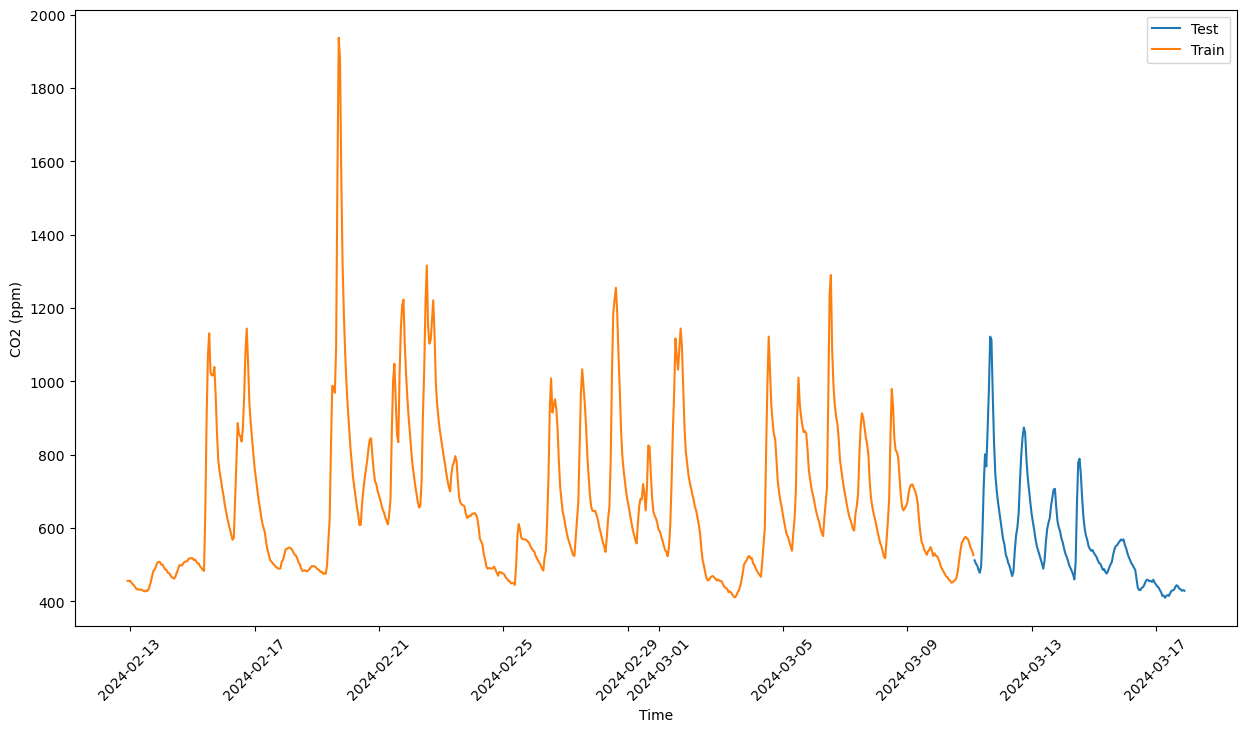

In [18]:
test_co2 = df[df.index >= test_start_dt]["CO2 (ppm)"]
train_co2 = df[(df.index < test_start_dt) & (df.index >= train_start_dt)]["CO2 (ppm)"]

plt.figure(figsize=(15, 8))
plt.plot(test_co2.index, test_co2.values, label='Test')

plt.plot(train_co2.index, train_co2.values, label='Train')

plt.xlabel('Time')
plt.ylabel('CO2 (ppm)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Data preparation

In [19]:
train_co2_reshaped = train_co2.values.reshape(-1, 1)
test_co2_reshaped = test_co2.values.reshape(-1, 1)

In [20]:
print("Training data shape: ", train_co2_reshaped.shape)
print("Test data shape: ", test_co2_reshaped.shape)

Training data shape:  (652, 1)
Test data shape:  (163, 1)


In [21]:
scaler = MinMaxScaler()
train_co2_scaled = scaler.fit_transform(train_co2_reshaped)
train_co2_scaled = pd.DataFrame(train_co2_scaled.flatten(), index=train_co2.index, columns=["CO2 (ppm)"])
train_co2_scaled.head(10)

,CO2 (ppm)
Time,
2024-02-12 22:00:00,0.029489
2024-02-12 23:00:00,0.029489
2024-02-13 00:00:00,0.029489
2024-02-13 01:00:00,0.025557
2024-02-13 02:00:00,0.023591
2024-02-13 03:00:00,0.020970
2024-02-13 04:00:00,0.017693
2024-02-13 05:00:00,0.014417
2024-02-13 06:00:00,0.014417


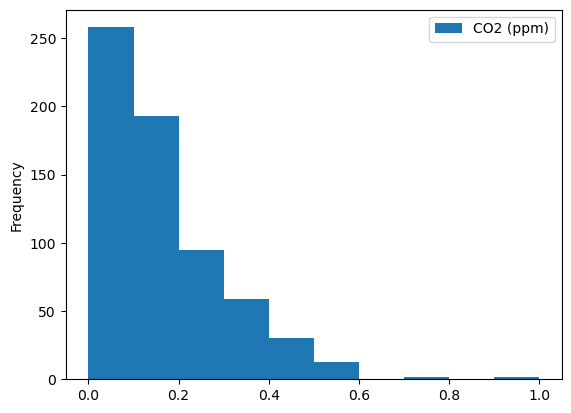

In [22]:
train_co2_scaled.plot.hist(bins=10)
plt.show()

In [23]:
test_co2_scaled = scaler.fit_transform(test_co2_reshaped)
test_co2_scaled = pd.DataFrame(test_co2_scaled.flatten(), index=test_co2.index, columns=["CO2 (ppm)"])
test_co2_scaled.head(10)

,CO2 (ppm)
Time,
2024-03-11 04:00:00,0.143258
2024-03-11 05:00:00,0.130618
2024-03-11 06:00:00,0.123596
2024-03-11 07:00:00,0.106742
2024-03-11 08:00:00,0.095506
2024-03-11 09:00:00,0.119382
2024-03-11 10:00:00,0.242978
2024-03-11 11:00:00,0.424157
2024-03-11 12:00:00,0.549157


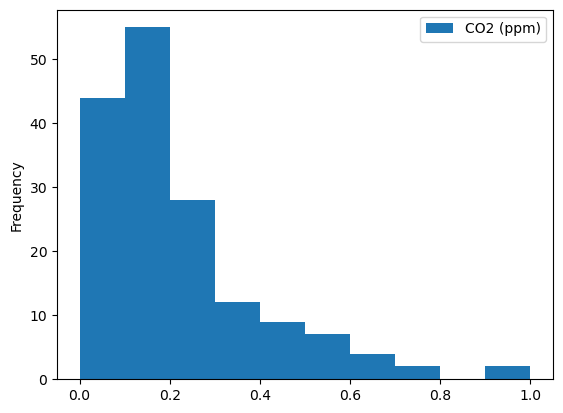

In [24]:
test_co2_scaled.plot.hist(bins=10)
plt.show()

In [25]:
HORIZON_CO2 = 1

In [26]:
stepwise_fit_co2 = auto_arima(train_co2_scaled, trace=True, suppress_warnings=True)
stepwise_fit_co2.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-2777.560, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-727.863, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2359.903, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1529.519, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-130.303, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-2772.865, Time=0.73 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-2772.977, Time=0.30 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-2773.590, Time=1.42 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-2775.415, Time=4.89 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2704.827, Time=0.37 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-2779.924, Time=6.78 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-2412.965, Time=2.82 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-2778.925, Time=12.47 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-2082.649, Time=0.69 sec
 ARIMA(0,0,4)(0,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  652
Model:               SARIMAX(1, 0, 3)   Log Likelihood                1395.962
Date:                Sun, 17 Mar 2024   AIC                          -2779.924
Time:                        22:24:24   BIC                          -2753.043
Sample:                             0   HQIC                         -2769.499
                                - 652                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0220      0.007      3.266      0.001       0.009       0.035
ar.L1          0.8680      0.018     47.048      0.000       0.832       0.904
ma.L1          0.9426      0.019     48.912      0.000       0.905       0.980
ma.L2          0.4904      0.035     14.034      0.000       0.422       0.559
ma.L3          0.1383      0.031      4.515      0.000       0.078       0.198
sigma2         0.0008   1.75e-05     46.015      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              8963.66
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             2.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
order_co2 = (1,0,3)

In [28]:
model_temp =  ARIMA(endog=train_co2_scaled, order=order_co2)
result_temp = model_temp.fit()

print(result_temp.summary())

                               SARIMAX Results                                
Dep. Variable:              CO2 (ppm)   No. Observations:                  652
Model:                 ARIMA(1, 0, 3)   Log Likelihood                1395.962
Date:                Sun, 17 Mar 2024   AIC                          -2779.924
Time:                        22:24:27   BIC                          -2753.043
Sample:                             0   HQIC                         -2769.499
                                - 652                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1668      0.034      4.929      0.000       0.100       0.233
ar.L1          0.8680      0.018     47.039      0.000       0.832       0.904
ma.L1          0.9427      0.019     48.915      0.0

Walk-forward validation

Create a test data point for each HORIZON.<br>
Shift the data horizontally according to its horizon point.

In [29]:
test_co2_shifted = test_co2_scaled.copy()

for t in range(1, HORIZON_CO2):
    test_co2_shifted["CO2 (ppm)+" + str(t)] = test_co2_shifted["CO2 (ppm)"].shift(-t, freq='H')
    
test_co2_shifted = test_co2_shifted.dropna(how='any')
test_co2_shifted.head()

,CO2 (ppm)
Time,
2024-03-11 04:00:00,0.143258
2024-03-11 05:00:00,0.130618
2024-03-11 06:00:00,0.123596
2024-03-11 07:00:00,0.106742
2024-03-11 08:00:00,0.095506


Make predictions on the test data using a sliding window approach in a loop the size of the test data length.

In [30]:
stepwise_fit_co2_test = auto_arima(test_co2_scaled, trace=True, suppress_warnings=True)
stepwise_fit_co2_test.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-613.770, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-483.759, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-583.650, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-577.761, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-485.730, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-613.214, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-608.396, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-612.700, Time=0.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-621.107, Time=1.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-617.603, Time=1.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-610.649, Time=1.31 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-621.679, Time=7.75 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-624.317, Time=6.71 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-614.671, Time=4.93 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  163
Model:               SARIMAX(1, 1, 4)   Log Likelihood                 319.158
Date:                Sun, 17 Mar 2024   AIC                           -624.317
Time:                        22:25:54   BIC                           -602.704
Sample:                    03-11-2024   HQIC                          -615.541
                         - 03-17-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0005      0.001     -0.933      0.351      -0.002       0.001
ar.L1          0.7626      0.066     11.547      0.000       0.633       0.892
ma.L1          0.1514      0.178      0.849      0.396      -0.198       0.501
ma.L2         -0.2646      0.203     -1.304      0.192      -0.662       0.133
ma.L3         -0.5576      0.158     -3.529      0.000      -0.867      -0.248
ma.L4         -0.2874      0.063     -4.579      0.000      -0.410      -0.164
sigma2         0.0011      0.000      6.916      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2679.82
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                             3.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
test_co2_shifted

,CO2 (ppm)
Time,
2024-03-11 04:00:00,0.143258
2024-03-11 05:00:00,0.130618
2024-03-11 06:00:00,0.123596
2024-03-11 07:00:00,0.106742
2024-03-11 08:00:00,0.095506
...,...
2024-03-17 18:00:00,0.035112
2024-03-17 19:00:00,0.032303
2024-03-17 20:00:00,0.026685


In [32]:
%%time
training_window = 168

train_ts_co2 = train_co2_scaled["CO2 (ppm)"]
test_ts_co2 = test_co2_shifted

history_co2 = [x for x in train_ts_co2]
history_co2 = history_co2[(-training_window):]

predictions_co2 = list()

# order = (1,0,3)

for t in range(test_ts_co2.shape[0]):
    model_co2 = ARIMA(endog=history_co2, order=order_co2)
    model_fit_co2 = model_co2.fit()
    yhat = model_fit_co2.forecast(steps = HORIZON_CO2)
    predictions_co2.append(yhat)
    obs = list(test_ts_co2.iloc[t])
    # move the training window
    history_co2.append(obs[0])
    history_co2.pop(0)
    print(test_ts_co2.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2024-03-11 04:00:00
1 : predicted = [0.07384572] expected = [0.1432584269662921]
2024-03-11 05:00:00
2 : predicted = [0.21269004] expected = [0.1306179775280899]
2024-03-11 06:00:00
3 : predicted = [0.08843889] expected = [0.1235955056179775]
2024-03-11 07:00:00
4 : predicted = [0.13012929] expected = [0.10674157303370779]
2024-03-11 08:00:00
5 : predicted = [0.11196615] expected = [0.0955056179775281]
2024-03-11 09:00:00
6 : predicted = [0.09168383] expected = [0.1193820224719101]
2024-03-11 10:00:00
7 : predicted = [0.14627746] expected = [0.2429775280898876]
2024-03-11 11:00:00
8 : predicted = [0.32800838] expected = [0.4241573033707865]
2024-03-11 12:00:00
9 : predicted = [0.51862512] expected = [0.5491573033707865]
2024-03-11 13:00:00
10 : predicted = [0.57375365] expected = [0.5028089887640449]
2024-03-11 14:00:00
11 : predicted = [0.39806629] expected = [0.6390449438202247]
2024-03-11 15:00:00
12 : predicted = [0.77873895] expected = [0.7921348314606741]
2024-03-11 16:00:00
13 :

Compare the prediction against the actual CO2.

In [33]:
eval_df_co2 = pd.DataFrame(predictions_co2, columns=['t+'+str(t) for t in range(1, HORIZON_CO2+1)])
eval_df_co2['Time'] = test_co2_scaled.index[0:len(test_co2_scaled.index)-HORIZON_CO2+1]
eval_df_co2 = pd.melt(eval_df_co2, id_vars='Time', value_name='Prediction', var_name='H')
eval_df_co2['Actual'] = np.array(np.transpose(test_ts_co2)).ravel()
eval_df_co2[['Prediction', 'Actual']] = scaler.inverse_transform(eval_df_co2[['Prediction', 'Actual']])
eval_df_co2.head()

,Time,H,Prediction,Actual
0,2024-03-11 04:00:00,t+1,462.578154,512.0
1,2024-03-11 05:00:00,t+1,561.435307,503.0
2,2024-03-11 06:00:00,t+1,472.968492,498.0
3,2024-03-11 07:00:00,t+1,502.652056,486.0
4,2024-03-11 08:00:00,t+1,489.719896,478.0


Check the model accuracy by testing its mean absolute percentage error (MAPE) over all the predictions.

In [34]:
if (HORIZON_CO2 > 1):
    eval_df_co2['APE'] = (eval_df_co2['Prediction'] - eval_df_co2['Actual']).abs()
    print(eval_df_co2.groupby('H')['APE'].mean())

In [35]:
# Mean absolute percentage error
def mape(predictions, actuals):
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    return (np.absolute(predictions - actuals) / actuals).mean()

In [36]:
print('Multi-step forecast MAPE: ', mape(eval_df_co2['Prediction'], eval_df_co2['Actual'])*100, '%')

Multi-step forecast MAPE:  2.4485902633397134 %


In [37]:
rmse_co2 = sqrt(mean_squared_error(eval_df_co2['Prediction'], eval_df_co2['Actual']))
rmse_co2

27.7938168282031

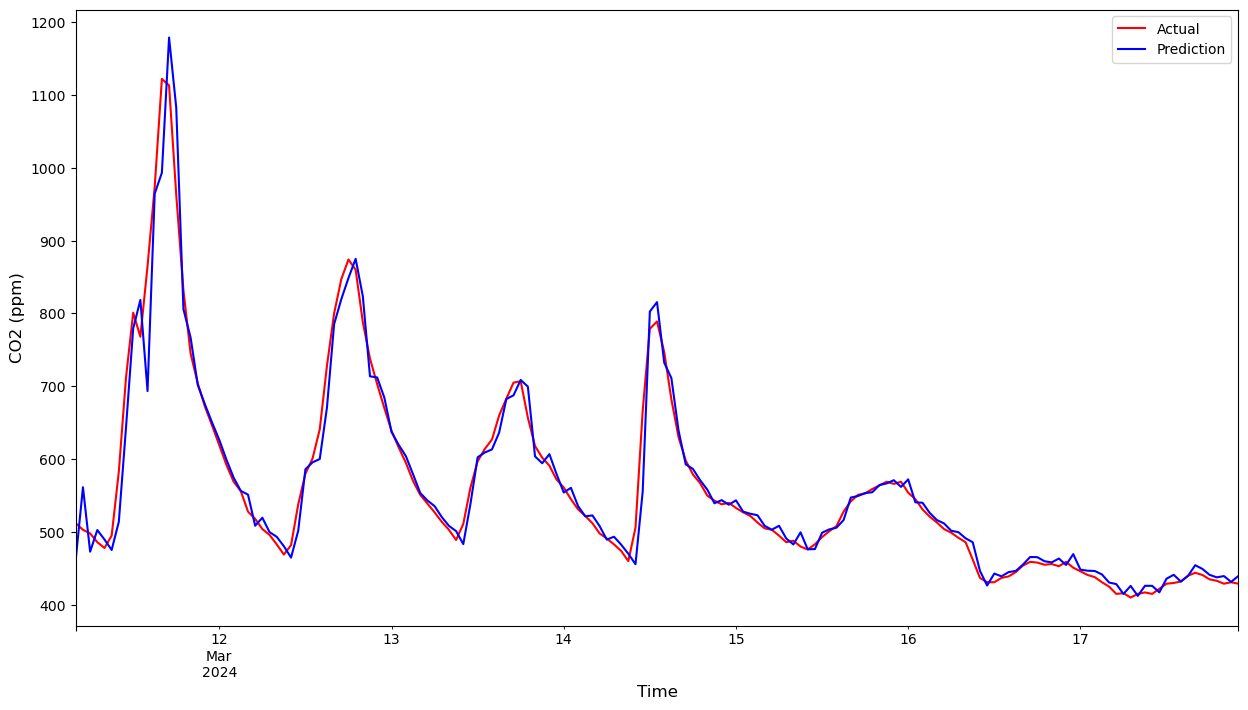

In [38]:
if HORIZON_CO2 == 1:
    eval_df_co2.plot(x='Time', y=['Actual', 'Prediction'], style=['r', 'b'], figsize=(15, 8))
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('CO2 (ppm)', fontsize=12)
    plt.legend(['Actual', 'Prediction'], loc='best')
    plt.show()
else:
    plot_df_co2 = eval_df_co2[(eval_df_co2.H == 't+1')][['Time', 'Actual']]
    for t in range(1, HORIZON_CO2 + 1):
        plot_df_co2['t+' + str(t)] = eval_df_co2[(eval_df_co2.H == 't+' + str(t))]['Prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.plot(plot_df_co2['Time'], plot_df_co2['Actual'], color='red', linewidth=4.0, label='Actual')
    for t in range(1, HORIZON_CO2 + 1):
        x = plot_df_co2['Time'][(t - 1):]
        y = plot_df_co2['t+' + str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4 * math.pow(.9, t), alpha=math.pow(0.8, t),
                label='Prediction t+' + str(t))

    ax.legend(loc='best')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('CO2', fontsize=12)
    plt.show()

In [39]:
next_hour = pd.date_range(start=df.index[-1], periods=2, freq='H')[-1]

In [40]:
pred_co2 = model_fit_co2.predict(start=len(df), end=len(df), typ="levels")[0]
pred_co2_nonscaled = round(scaler.inverse_transform(np.array(pred_co2).reshape(-1, 1))[0][0], 1)
print(f"{next_hour} {pred_co2_nonscaled}")

2024-03-17 23:00:00 551.5
